In [1]:
from xgboost import XGBClassifier
from tqdm import tqdm
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Load data

In [ ]:
from dataset import GetMedMNIST

d_size = 28

data_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.detach().numpy()),
])

train_dataloader = GetMedMNIST(name='PathMNIST', split='train', size=d_size, hf=False, transform=data_transform)
valid_dataloader = GetMedMNIST(name='PathMNIST', split='val', size=d_size, hf=False, transform=data_transform)
test_dataloader = GetMedMNIST(name='PathMNIST', split='test', size=d_size, hf=False, transform=data_transform)

train_loader = DataLoader(train_dataloader, batch_size=len(train_dataloader.dataset), shuffle=False)
train_x, train_y = next(iter(train_loader))[0].reshape(-1, d_size**2), next(iter(train_loader))[1].detach().numpy()

valid_loader = DataLoader(valid_dataloader, batch_size=len(valid_dataloader.dataset))
valid_x, valid_y = next(iter(valid_loader))[0].reshape(-1, d_size**2), next(iter(valid_loader))[1].detach().numpy()

test_loader = DataLoader(test_dataloader, batch_size=len(test_dataloader.dataset))
test_x, test_y = next(iter(test_loader))[0].reshape(-1, d_size**2), next(iter(test_loader))[1].detach().numpy()

# Train

In [4]:
model = XGBClassifier(n_estimators=200, objective='multi:softmax', num_class=train_dataloader.n_classes, device='cuda')

model.fit(train_x, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_class=9, ...)

In [5]:
y_true = test_y
y_pred = model.predict(test_x)

# Evaluation

In [6]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report

def eval_model(labels, preds):
    cf_matrix = confusion_matrix(labels, preds)
    sns.heatmap(cf_matrix, annot=True, cmap='coolwarm', fmt='.0f')

    acc = accuracy_score(labels, preds)

    f1 = f1_score(labels, preds, average='weighted')

    class_report = classification_report(labels, preds)
    print(f'model accuracy: {acc*100:.2f}, f1 weighted: {f1:.4f}')
    print(class_report)

model accuracy: 64.73, f1 weighted: 0.6433
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      1041
           1       0.97      0.84      0.90      1057
           2       0.46      0.33      0.39      1152
           3       0.77      0.84      0.81      1156
           4       0.55      0.60      0.57       890
           5       0.54      0.55      0.55      1354
           6       0.58      0.53      0.55       877
           7       0.46      0.46      0.46      1045
           8       0.59      0.70      0.64      1432

    accuracy                           0.65     10004
   macro avg       0.65      0.65      0.64     10004
weighted avg       0.65      0.65      0.64     10004



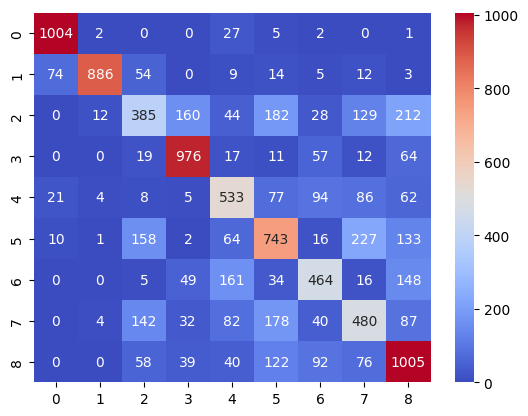

In [7]:
eval_model(y_true, y_pred)

ROC Score: 0.931


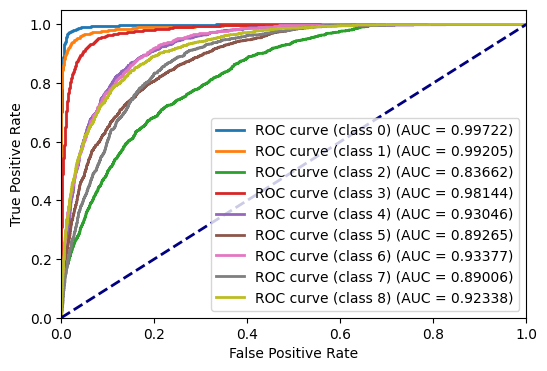

In [15]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import torch

true_labels = test_y.ravel()
predictions = model.predict_proba(test_x)

roc_score = roc_auc_score(true_labels, predictions, multi_class='ovo', average='weighted')
print(f"ROC Score: {roc_score:.3f}")

num_classes = predictions.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve((true_labels == i).astype(int), predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(6, 4))

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (class %d) (AUC = %0.5f)' % (i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()